# Árvores II - Tarefa 2

### 1. Carregar as bases

Vamos carregar as bases lidas na tarefa passada. Se você salvou essas bases em arquivo texto, basta fazer a leitura com o comando ```pd.read_csv``` das seguintes bases:

- X_train
- Y_train
- X_test
- Y_test

Não se esqueça de considerar a leitura dos índices dos arquivos no ```read_csv()```!

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [22]:
x_train_df = pd.read_csv("uci_har_dataset/train/X_train.txt", header=None, delim_whitespace=True)
x_test_df = pd.read_csv("uci_har_dataset/test/X_test.txt", header=None, delim_whitespace=True)
y_train_df = pd.read_csv("uci_har_dataset/train/y_train.txt", header=None, delim_whitespace=True)
y_test_df = pd.read_csv("uci_har_dataset/test/y_test.txt", header=None, delim_whitespace=True)
X_train = pd.read_csv("uci_har_dataset/x_train.csv", index_col=["order", "subject_train"], sep=",")
X_test = pd.read_csv("uci_har_dataset/x_test.csv", index_col=["order", "subject_test"], sep=",")

### 2. Divisão da base em Treino, Validação e Teste

A base já se encontra dividida em Treino e Validação. O que vamos fazer então é extrair uma base de Validação da base de Treino.

Extraia 25% da base de treino como base de validação.

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train_df, test_size=.25, random_state=1729)

### 3. Melhores 3 variáveis

Rode uma árvore com profundidade máxima igual a 4 para prever a atividade humana com todas as variáveis.
Observe a importância das variáveis e considere as 3 variáveis com maior importância para os próximos passos.
Dica: utilize o atributo ```clf.feature_importances_``` da árvore treinada.

In [44]:
clf = DecisionTreeClassifier(random_state=2360873, max_depth=4).fit(X_train, y_train)
variaveis_com_maior_importancia = []

feature_importances = clf.feature_importances_

# Criando um DataFrame para melhor visualização
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Mostrando as 3 variáveis mais importantes
top_3_features = feature_importance_df.head(3)
top_3_features["Feature"].values.tolist()

['tGravityAcc-energy()-X', 'fBodyAcc-mean()-X', 'angle(Y,gravityMean)']

### 4. Construa uma árvore com as 3 melhores variáveis

Utilizando as três variáveis encontradas acima, construa uma árvore de decisão. Encontre o melhor ```ccp_alpha``` utilizando a base de validação, conforme a estrutura que vimos em aula.

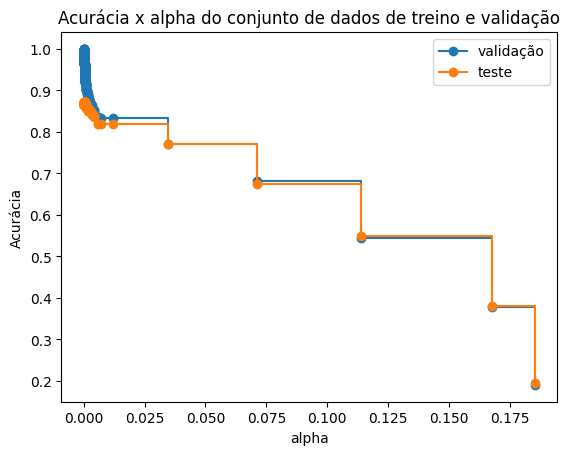

CPU times: user 7.48 s, sys: 168 ms, total: 7.65 s
Wall time: 7.47 s


In [48]:
# %%time
columns = ['tGravityAcc-energy()-X', 'fBodyAcc-mean()-X', 'angle(Y,gravityMean)']
X_train = pd.DataFrame(X_train, columns=columns)
X_valid = pd.DataFrame(X_valid, columns=columns)

caminho = DecisionTreeClassifier(random_state=2360873).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(X_train, y_train)
    clfs.append(clf)
    
train_scores = [clf.score(X_train, y_train) for clf in clfs]
valid_scores = [clf.score(X_valid, y_valid) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e validação")
ax.plot(ccp_alphas, train_scores, marker='o', label="validação",
        drawstyle="steps-post")
ax.plot(ccp_alphas, valid_scores, marker='o', label="teste",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [49]:
ind_melhor_arvore = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de validação: {valid_scores[ind_melhor_arvore]*100:.2f}')

melhor_arvore

Acurácia da melhor árvore na base de validação: 87.21


DecisionTreeClassifier(ccp_alpha=0.00040502962156933864, random_state=2360873)

### 5. Avaliação do modelo

Avalie a árvore encontrada no item anterior na base de testes.

Acurácia: 69.94


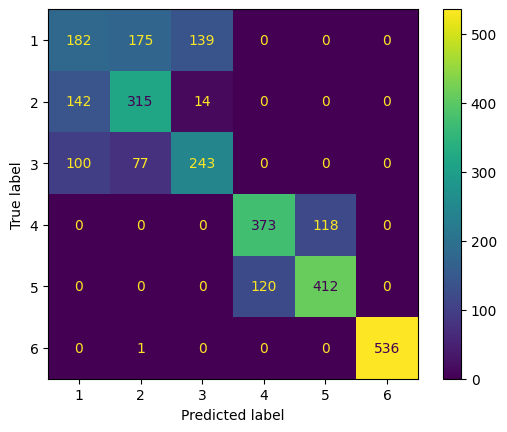

In [57]:
X_test = pd.DataFrame(X_test, columns=columns)
acuracia_teste = melhor_arvore.score(X_test, y_test_df)

print(f'Acurácia: {acuracia_teste*100:.2f}')

ConfusionMatrixDisplay.from_estimator(estimator=melhor_arvore, X=X_test, y=y_test_df)